# DeepDream with Inception V3 Model

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import os

BASE_PATH = '/content/drive/My Drive/Colab Notebooks/deep_dream/'
INPUT_DIR = os.path.join(BASE_PATH, 'input/')
OUTPUT_DIR = os.path.join(BASE_PATH, 'output/')

print("Input Dir:\t" + str(os.listdir(INPUT_DIR)))
print("Output Dir:\t" + str(os.listdir(OUTPUT_DIR)))

Input Dir:	['IMG_3.jpg', 'IMG_2.jpg', 'IMG_1.jpg']
Output Dir:	[]


##Prerequisites

In [0]:
import sys
import numpy as np

import IPython.display as display
import PIL.Image
import IPython.display as clear_output

import tensorflow as tf

In [0]:
def load(filename, max_dim=None):
  ''' LOAD IMAGE
  filename  -- string
  max_dim   -- integer

  returns   -- numpy array
  '''
  filepath = os.path.join(INPUT_DIR, filename)
  try:
    img = PIL.Image.open(filepath)
  except:
    print("Failed to load the file!")

  if max_dim:
    img.thumbnail((max_dim, max_dim))

  return np.array(img)

def save(img, filename):
  ''' SAVE IMAGE
  img       -- numpy array
  filename  -- string

  returns   -- numpy array
  '''
  print(type(img))
  filepath = os.path.join(OUTPUT_DIR, filename)
  image = np.clip(img, 0, 255).astype('uint8')
  try:
    PIL.Image.fromarray(image).save(filepath, format='png')
  except:
    print("Failed to save the file!")

def show(img):
  ''' SHOW IMAGE
  img       -- numpy array
  '''
  try:
    display.display(PIL.Image.fromarray(img))
  except:
    display.display(PIL.Image.fromarray(img.numpy()))

#Import Model

In [0]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

#layer_names = ['mixed1','mixed2','mixed3', 'mixed5', 'mixed7', 'mixed8', 'mixed9', 'mixed10']
layer_names = ['mixed3','mixed7']
layers = [base_model.get_layer(name).output for name in layer_names]

model = tf.keras.Model(inputs=base_model.input, outputs=layers)

#Optimization

In [0]:
def compute_cost(img):
  img = tf.expand_dims(img, axis=0)
  activations = model(img)

  losses=[]
  for a in activations:
    loss = tf.math.reduce_mean(a)
    losses.append(loss)

  return tf.reduce_sum(losses)


In [0]:
@tf.function(
    input_signature=(
      tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
      tf.TensorSpec(shape=[], dtype=tf.float32))
)
def gradient_ascent(img, step_size):
  with tf.GradientTape() as g:
    g.watch(img)
    J = compute_cost(img)
  
  grad = g.gradient(J, img)
  grad /= (tf.math.reduce_std(grad) + tf.constant(1e-10))
  """
  sigma = (i * 4.0) / num_iterations + 0.5
  grad_smooth1 = gaussian_filter(grad, sigma=sigma)
  grad_smooth2 = gaussian_filter(grad, sigma=sigma*2)
  grad_smooth3 = gaussian_filter(grad, sigma=sigma*0.5)
  grad = (grad_smooth1 + grad_smooth2 + grad_smooth3)
  """
  step_size_scaled = step_size / (tf.math.reduce_std(grad) + tf.constant(1e-10))
  img = img + grad * step_size_scaled

  return J, img

In [0]:
def optimize_image(layer, image, num_iterations, step_size):
  img = tf.keras.applications.inception_v3.preprocess_input(image)
  img = tf.convert_to_tensor(img, dtype=tf.float32)
  num_iterations = tf.constant(num_iterations)
  step_size = tf.convert_to_tensor(step_size)

  for i in range(num_iterations):
    J, img = gradient_ascent(img, step_size)
    #print("Step=" + str(i) + ", Cost=" + str(J))

  return img

In [0]:
def gaussian_blur(img, kernel_size=11, sigma=5):
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel

    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]

    return tf.nn.depthwise_conv2d(input=img, filter=gaussian_kernel, strides=[1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')

In [0]:
def dream(layer, image, num_recursions, rescale_factor, blend, num_iterations, step_size):
  img = tf.constant(np.array(image))
  base_shape = tf.shape(img)[:-1]
  float_base_shape = tf.cast(base_shape, tf.float32)

  if num_recursions>0:
    img_blurred = tf.identity(img)#gaussian_blur(img)

    new_shape = tf.cast(float_base_shape*(rescale_factor), tf.int32)

    img_scaled = tf.image.resize(img_blurred, new_shape).numpy()

    img_result = dream(layer=layer,
                            image=img_scaled,
                            num_recursions=num_recursions-1,
                            rescale_factor=rescale_factor,
                            blend=blend,
                            num_iterations=num_iterations,
                            step_size=step_size)
  
    img_rescaled = tf.image.resize(img_result, base_shape)
    img = tf.image.convert_image_dtype(img_rescaled/255.0, dtype=tf.uint8)
    image = blend * image + (1.0 - blend) * img_rescaled
  
  #display.clear_output(wait=True)
  print("\nRecursion: " + str(num_recursions))
  img_result = optimize_image(layer=layer,
                              image=image,
                              num_iterations=num_iterations,
                              step_size=step_size)
  #show(image)
  return img_result.numpy()

In [0]:
params = {"num_iterations": 10,
          "step_size": 3.0,
          "rescale_factor": 0.7,
          "num_recursions": 4,
          "blend": 0.2}

In [0]:
def random_roll(img, maxroll):
  ''' TO AVOID TILE SEAMS
  img       -- numpy array
  max       -- integer

  returns   -- integer, integer, numpy array
  '''
  dx, dy = np.random.randint(low=-maxroll, high=maxroll, size=(2,))
  img_rolled = np.roll(np.roll(img, dy, axis=0), dx, axis=1)
  return dy, dx, img_rolled

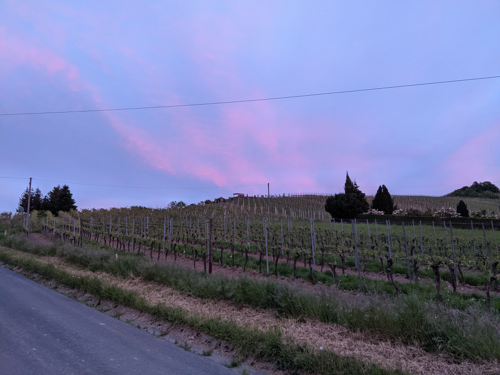

In [38]:
FILENAME = "IMG_1.jpg"
image = load(FILENAME, 500)
#image = tf.convert_to_tensor(image, dtype=tf.float32)
show(image)

In [29]:
%xmode Plain

Exception reporting mode: Plain


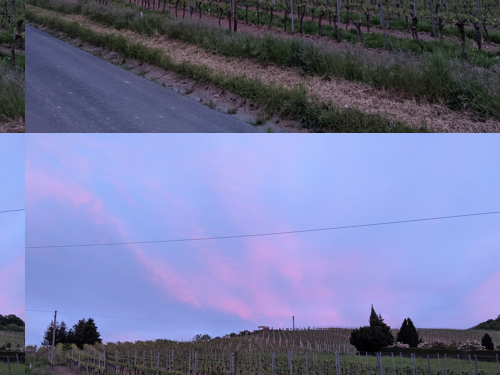

In [43]:
dy, dx, img_rolled = random_roll(image, 512)

show(img_rolled)

In [49]:
results = []
for layer in layers:
  result = dream(layer=layer, image=img_rolled, **params)
  results.append(result)


Recursion: 0

Recursion: 1

Recursion: 2

Recursion: 3

Recursion: 4

Recursion: 0

Recursion: 1

Recursion: 2

Recursion: 3

Recursion: 4


In [51]:
for i, result in enumerate(results):
  image_save=save(result,  str(i) + "_" + FILENAME)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [42]:
show(results[0])

TypeError: ignored